In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_retrain
from exp_hp import get_hp

2025-01-28 10:48:01.748976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-28 10:48:02.069309: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Num GPUs Available:  0


In [4]:
%%time
EXP_NAME = 'exp2_kfold'
EXP_NAME2 = 'exp2_retrain_increase_kfold'
hps = get_hp(EXP_NAME)
hps2 = get_hp(EXP_NAME2)

all_confcutoffs = []

for kk in np.arange(0,20):
    print('Validation Member: '+str(hps2['val_mems'][kk][0]))
    print('Testing Member: '+str(hps2['test_mems'][kk][0]))
    
    for i_trainmems in np.arange(8,9):
        print('Training Members: '+str(hps2['train_mems'][kk][i_trainmems]))
    
        _, _, X1test, _, _, Y1test,_ = split_retrain(trainmems = hps2['train_mems'][kk][i_trainmems],
                                                          valmem = hps2['val_mems'][kk][0],
                                                          testmem = hps2['test_mems'][kk][0],
                                                          months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                          lead = hps2['LEAD'])
    
        X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))
        
        
        #----- SET UP & TRAIN NN -----
        GLOBAL_SEED = hps['GLOBAL_SEED']
        np.random.seed(GLOBAL_SEED)
        random.seed(GLOBAL_SEED)
        tf.random.set_seed(GLOBAL_SEED)
    
        acc_all = []
        for SEED in range(10):
            print(SEED)
            annfi_name = 'ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'_seed'+str(SEED)+'.h5'
            ann = tf.keras.models.load_model(base_dir+'train/saved_models/kfold/'+annfi_name)
    
            pred = ann.predict(X1test)
            acc = []
            predconf = np.max(pred,axis=-1)
            predval  = np.argmax(pred,axis=-1)

            q = 80
            all_confcutoffs.append(np.percentile(predconf,q=q))
        #     for q in range(100):
        #         iconf = np.where(predconf >= np.percentile(predconf,q=q))
        #         icorr = np.where(predval[iconf] == Y1test[iconf])
    
        #         acc.append((len(icorr[0])/len(iconf[0]))*100)
        #     plt.plot(acc)
        #     plt.ylim(50,100)
    
        #     acc_all.append(acc)
        # plt.show()
        # np.save(base_dir+'test/confvsacc/kfold/confvsacc_ann2_60Eshift_'+EXP_NAME2+'.'+str(kk)+'.'+str(i_trainmems)+'_ann1-'+EXP_NAME+'.npy', acc_all, allow_pickle=True)

Validation Member: 0301
Testing Member: 0101
Training Members: ['0211', '0221', '0231', '0241', '0251', '0261', '0271', '0281', '0291']
loading data & saving
0


2025-01-28 10:49:05.044556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


242/242 [==============================] - 1s 1ms/step
1
242/242 [==============================] - 0s 1ms/step
2
242/242 [==============================] - 0s 1ms/step
3
242/242 [==============================] - 0s 1ms/step
4
242/242 [==============================] - 0s 1ms/step
5
242/242 [==============================] - 0s 1ms/step
6
242/242 [==============================] - 0s 1ms/step
7
242/242 [==============================] - 0s 1ms/step
8
242/242 [==============================] - 0s 1ms/step
9
242/242 [==============================] - 0s 1ms/step
Validation Member: 0101
Testing Member: 0111
Training Members: ['0221', '0231', '0241', '0251', '0261', '0271', '0281', '0291', '0301']
loading data & saving
0
227/227 [==============================] - 0s 1ms/step
1
227/227 [==============================] - 0s 788us/step
2
227/227 [==============================] - 0s 1ms/step
3
227/227 [==============================] - 0s 1ms/step
4
227/227 [==============================] -

In [5]:
print(np.min(all_confcutoffs))
print(np.max(all_confcutoffs))
print(np.mean(all_confcutoffs))
print(np.median(all_confcutoffs))

0.557394003868103
0.6374890208244324
0.6070121015906333
0.6078025996685028


(array([ 1.,  1.,  8., 15., 17., 35., 57., 36., 25.,  5.]),
 array([0.557394  , 0.56540351, 0.57341301, 0.58142251, 0.58943201,
        0.59744151, 0.60545101, 0.61346052, 0.62147002, 0.62947952,
        0.63748902]),
 <BarContainer object of 10 artists>)

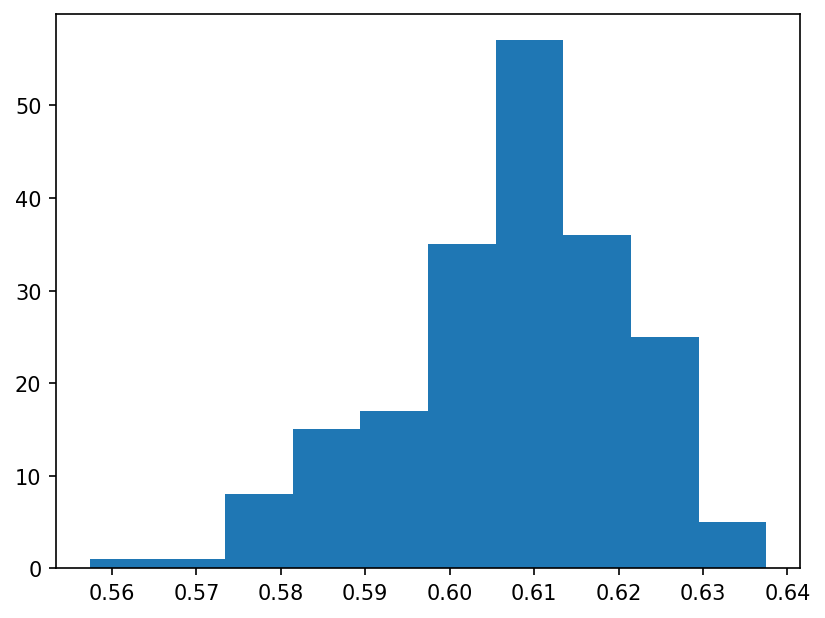

In [6]:
plt.hist(all_confcutoffs)